In [1]:
from brian2 import *
prefs.codegen.target = 'numpy'

All examples (slighty adapted) from https://brian2.readthedocs.io

## f/I curve of an LIF model (Examples: `IF_curve_LIF.py`)

In [21]:
start_scope()  # only necessary when running multiple examples in the same session, e.g. notebook

duration = 1*second
N_neurons = 100
C = 200*pF
g_L = 10*nS
V_rest = -70*mV
V_threshold = -50*mV
V_reset = V_rest

eqs = '''
dV/dt = (I_stim + g_L*(V_rest - V)) / C : volt (unless refractory)
I_stim : amp (constant)
'''
group = NeuronGroup(N_neurons, eqs, threshold='V > V_threshold', reset='V = V_reset',
                    refractory=5*ms, method='euler')
group.V = 0*mV
group.I_stim = '3*nA * i / (N_neurons-1)'

print('Strongest current leads to steady state voltage', group.I_stim[-1]/g_L)

monitor = SpikeMonitor(group)
v_monitor = StateMonitor(group, 'V', record=True)
run(duration)

Strongest current leads to steady state voltage 300. mV


(200.0, 250.0)

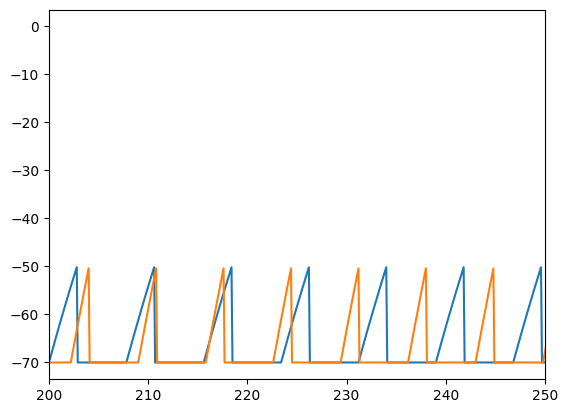

In [24]:
plt.plot(v_monitor.t/ms, v_monitor.V[50]/mV)
plt.plot(v_monitor.t/ms, v_monitor.V[75]/mV)
plt.xlim(200, 250)

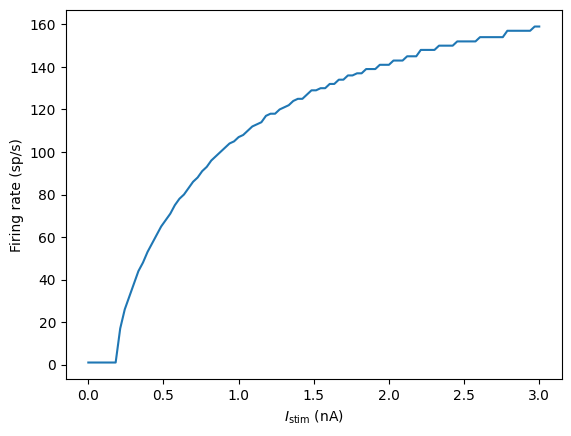

In [20]:
plt.plot(group.I_stim/nA, monitor.count / duration)
plt.xlabel(r'$I_\mathrm{stim}$ (nA)')
plt.ylabel('Firing rate (sp/s)');

---


## Randomly connected network with exponential, current-based synapses
### Examples: `CUBA.py`

In [25]:
start_scope()

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV

eqs = '''
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
'''

P = NeuronGroup(4000, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')
P.v = 'Vr + rand() * (Vt - Vr)'
P.ge = 0*mV
P.gi = 0*mV

we = (60*0.27/10)*mV  # excitatory synaptic weight (voltage)
wi = (-20*4.5/10)*mV  # inhibitory synaptic weight
Ce = Synapses(P[:3200], P, on_pre='ge += we')
Ci = Synapses(P[3200:], P, on_pre='gi += wi')
Ce.connect(p=0.02)
Ci.connect(p=0.02)

s_mon = SpikeMonitor(P)

run(1 * second, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s


In [26]:
print(len(Ce), len(Ci))

255939 64092


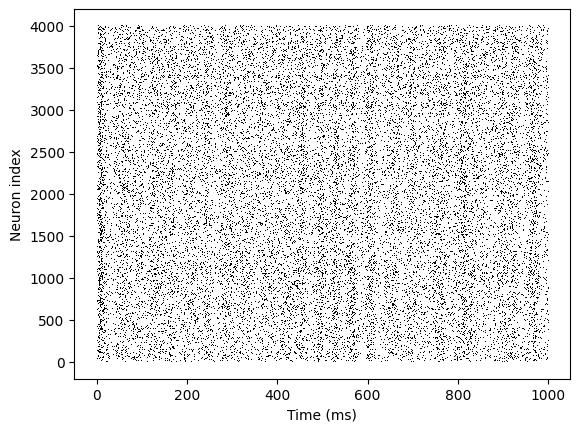

In [30]:
plt.plot(s_mon.t/ms, s_mon.i, ',k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index');

---

## Spike-timing dependent plasticity
### Examples: synapses → `STDP.py`

In [ ]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input_spikes = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input_spikes, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input_spikes)

run(50*second, report='text')

In [ ]:
plt.subplot(311)
plt.plot(S.w / gmax, '.k')
plt.ylabel('Weight / gmax')
plt.xlabel('Synapse index')
plt.subplot(312)
plt.hist(S.w / gmax, 20)
plt.ylabel('Weight / gmax')
plt.subplot(313)
plt.plot(mon.t/second, mon.w.T/gmax)
plt.xlabel('Time (s)')
plt.ylabel('Weight / gmax')
plt.tight_layout()